# Data Preprocessing

1. How do we load and preview the raw dataset?
2. What are the dataset dimensions, info summary, whitespace-only fields, and zero counts in numeric columns?
3. Which values are missing and how will we handle (drop, impute median, regression, mode) them?
4. Are there duplicate rows or IDs that must be removed?
5. Which columns are redundant or noisy and can be dropped safely?
6. What do basic descriptive statistics (mean, variance, std, min/max, quartiles) show?
7. How can we discretize Team1Score into meaningful bins?
8. Which observations are outliers (Z-score/IQR) and how should we treat or replace them? What do plots show?
9. How do we create audience bins for interpretability?
10. Which categorical features require label encoding?
11. What do key visualizations reveal about distributions and correlations?
12. How should we normalize or standardize numeric features (Min-Max, Z-Score)?

# Step 1: Import Python Libraries

In [1]:
# a) Core scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# b) Scikit-learn utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression

# Step 2: Load the Dataset

In [3]:
# a) Read CSV
df = pd.read_csv("CricketData.csv")

In [4]:
# b) Preview first rows
df.head()

,MatchID,Date,Team1,Team2,Team1Score,Team2Score,TossWinner,PlayerOfMatch,Stadium,Audience,Overs,RainAffected,Umpires,Weather,Code,Source
0,696,2010-11-26,england,South Africa,263.0,284.0,SOUTH AFRICA,Rashid Al Hasan,wankhede stadium,38655.0,-6.0,NaN,"virat rahim, kane iqbal",NaN,MH50KE,BCB
1,438,01-09-14,BAN,new zealand,269.0,278.0,Bangladesh,Babar Taylor,Wankhede Stadium,28904.0,46.0,1,"Babar Khan, Steve Kohli",RAINY,B8NHOJ,BCB
2,31,07-31-13,SRI LANKA,australia,274.0,258.0,sri lanka,NaN,gaddafi stadium,35123.0,34.0,NaN,"rohit rahim, joe iqbal",cloudy,QW1HUK,BCB
3,600,19/07/2015,New Zealand,India,265.0,242.0,New Zealand,Rohit Taylor,Chinnaswamy Stadium,123.0,37.0,0,"Shakib Morgan, Warner Root",overcast,7N3YTC,BCB
4,97,"Jan 03, 2016",pakistan,Afghanistan,248.0,NaN,pakistan,Rohit Al Hasan,wankhede stadium,38661.0,43.0,Y,"Rashid Smith, Steve Azam",cloudy,6IW5G2,BCB


# Step 3: Basic Structure

In [5]:
# a) Shape of dataset
df.shape

(840, 16)

In [6]:
# b) Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MatchID        840 non-null    int64  
 1   Date           708 non-null    object 
 2   Team1          840 non-null    object 
 3   Team2          840 non-null    object 
 4   Team1Score     781 non-null    object 
 5   Team2Score     776 non-null    object 
 6   TossWinner     774 non-null    object 
 7   PlayerOfMatch  773 non-null    object 
 8   Stadium        774 non-null    object 
 9   Audience       779 non-null    float64
 10  Overs          780 non-null    object 
 11  RainAffected   609 non-null    object 
 12  Umpires        774 non-null    object 
 13  Weather        772 non-null    object 
 14  Code           840 non-null    object 
 15  Source         840 non-null    object 
dtypes: float64(1), int64(1), object(14)
memory usage: 105.1+ KB


In [7]:
import numpy as np
import pandas as pd

# 1. Fix numeric columns
df['Team1Score'] = pd.to_numeric(df['Team1Score'], errors='coerce')
df['Team2Score'] = pd.to_numeric(df['Team2Score'], errors='coerce')
df['Audience']   = pd.to_numeric(df['Audience'], errors='coerce')
df['Overs']      = pd.to_numeric(df['Overs'], errors='coerce')

# 2. Fix date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 3. Fix RainAffected (convert to True/False/NaN)
df['RainAffected'] = df['RainAffected'].astype(str).str.strip().str.lower()
df['RainAffected'] = df['RainAffected'].replace({
    'yes': True, 'y': True, '1': True,
    'no': False, 'n': False, '0': False,
    'nan': np.nan, '': np.nan
})

# 4. Clean categorical text columns
text_cols = ['Team1','Team2','TossWinner','PlayerOfMatch',
             'Stadium','Umpires','Weather']

for col in text_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].str.replace(r'\s+', ' ', regex=True)

# 5. Drop redundant columns
df = df.drop(columns=['Code','Source'], errors='ignore')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   MatchID        840 non-null    int64         
 1   Date           124 non-null    datetime64[ns]
 2   Team1          840 non-null    object        
 3   Team2          840 non-null    object        
 4   Team1Score     756 non-null    float64       
 5   Team2Score     750 non-null    float64       
 6   TossWinner     840 non-null    object        
 7   PlayerOfMatch  840 non-null    object        
 8   Stadium        840 non-null    object        
 9   Audience       779 non-null    float64       
 10  Overs          764 non-null    float64       
 11  RainAffected   609 non-null    object        
 12  Umpires        840 non-null    object        
 13  Weather        840 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(8)
memory usage: 92.0+ 

In [ ]:
# 6. Handle Mixed Missing Value Indicators & Special Characters (Step 3 continued)
# Replace various forms of "missing" with actual NaN
# This addresses issues like "NULL", "?", "nan" strings mixed in data
missing_indicators = ["?", "NULL", "null", "NaN", "nan", "NA", "--", ""]
df.replace(missing_indicators, np.nan, inplace=True)

# 7. Remove Special Characters from Text Columns
# Example: "Player@" -> "Player", "Dhaka#" -> "Dhaka"
# This regex keeps only alphanumeric characters and spaces
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].str.replace(r'[^\w\s]', '', regex=True)

print("Cleaned special characters and standardized missing values.")

In [8]:
# c) Whitespace-only cells
whitespace_cols = []
for col in df.columns:
    if df[col].dtype == "object":
        if (df[col].astype(str).str.strip() == "").any():
            whitespace_cols.append(col)
whitespace_cols

[]

In [ ]:
# d) Detect Potential Typos (Fuzzy Matching)
# This helps identify "Dhaka" vs "dhka" or "Statistics" vs "Statistcs"
from difflib import get_close_matches

def check_typos(df, col, threshold=0.85):
    unique_vals = df[col].dropna().unique().astype(str)
    typos = {}
    seen = set()
    for val in unique_vals:
        if val in seen: continue
        # Find close matches in the same list
        matches = get_close_matches(val, unique_vals, n=3, cutoff=threshold)
        # If we found matches other than the word itself
        if len(matches) > 1:
            typos[val] = [m for m in matches if m != val]
            seen.update(matches)
    return typos

# Check for typos in categorical columns
for col in ['Stadium', 'Team1', 'Team2', 'Weather']:
    typos = check_typos(df, col)
    if typos:
        print(f"Potential typos in {col}: {typos}")

In [9]:
# d) Zero counts in numeric columns
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
df[numeric_cols].isin([0]).sum()

MatchID        0
Team1Score    23
Team2Score    22
Audience      24
Overs         26
dtype: int64

In [ ]:
# f) Logical Consistency Checks
# 1. Check for Negative Values in columns that shouldn't be negative
negative_issues = df[(df['Team1Score'] < 0) | (df['Team2Score'] < 0) | (df['Audience'] < 0)]
print(f"Rows with negative scores/audience: {len(negative_issues)}")

# 2. Check for Future Dates (Impossible in historical data)
future_dates = df[df['Date'] > pd.Timestamp.now()]
print(f"Rows with future dates: {len(future_dates)}")

# 3. Fix Logical Inconsistencies (Example)
# Convert negative values to absolute (assuming sign error)
cols_to_fix = ['Team1Score', 'Team2Score', 'Audience']
for col in cols_to_fix:
    df[col] = df[col].abs()

print("Logical inconsistencies checked and fixed.")

In [ ]:
# e) Handle Invalid Zeros
# Treat 0s as missing values for specific columns where 0 is not possible/valid
# We do this BEFORE imputation so they get filled correctly
cols_with_zero_issues = ['Team1Score', 'Team2Score', 'Audience', 'Overs']
df[cols_with_zero_issues] = df[cols_with_zero_issues].replace(0, np.nan)

# Check nulls again after replacing 0s
print("Nulls after replacing 0s with NaN:")
print(df[cols_with_zero_issues].isnull().sum())

# Step 4: Missing Value Analysis

In [10]:
# a Check missing values
df.isnull().sum()

MatchID            0
Date             716
Team1              0
Team2              0
Team1Score        84
Team2Score        90
TossWinner         0
PlayerOfMatch      0
Stadium            0
Audience          61
Overs             76
RainAffected     231
Umpires            0
Weather            0
dtype: int64

In [11]:
# b Remove missing values (optional)
df_removed_na = df.dropna()
df_removed_na.shape

(65, 14)

In [12]:
# c Impute numeric missing values
# Do NOT impute Audience here
median_imputer = SimpleImputer(strategy='median')
df[['Team1Score','Team2Score','Overs']] = median_imputer.fit_transform(
    df[['Team1Score','Team2Score','Overs']]
)

# Regression Imputation for Audience
temp_df = df[['Audience','Team1Score','Team2Score','Overs']]

train = temp_df[temp_df['Audience'].notnull()]
test  = temp_df[temp_df['Audience'].isnull()]

if len(test) > 0:  # Only run if missing values exist
    X_train = train[['Team1Score','Team2Score','Overs']]
    y_train = train['Audience']

    model = LinearRegression()
    model.fit(X_train, y_train)

    X_test = test[['Team1Score','Team2Score','Overs']]
    df.loc[df['Audience'].isnull(), 'Audience'] = model.predict(X_test)


In [13]:
# d Impute categorical (Mode)
cat_cols = df.select_dtypes(include='object').columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [15]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
median_date = df['Date'].median()
df['Date'] = df['Date'].fillna(median_date)

In [16]:
df.isnull().sum()

MatchID          0
Date             0
Team1            0
Team2            0
Team1Score       0
Team2Score       0
TossWinner       0
PlayerOfMatch    0
Stadium          0
Audience         0
Overs            0
RainAffected     0
Umpires          0
Weather          0
dtype: int64

# Step 5: Duplicate Data Handling

In [17]:
# a) Count duplicate rows
df.duplicated().sum()

34

In [18]:
# b) Duplicate MatchID (if exists)
if 'MatchID' in df.columns:
    df['MatchID'].duplicated().sum()

In [19]:
# c) Remove duplicates
df = df.drop_duplicates()

In [20]:
df.isnull().sum()

MatchID          0
Date             0
Team1            0
Team2            0
Team1Score       0
Team2Score       0
TossWinner       0
PlayerOfMatch    0
Stadium          0
Audience         0
Overs            0
RainAffected     0
Umpires          0
Weather          0
dtype: int64

In [21]:
df.duplicated().sum()

0

# Step 6: Feature Engineering
Create new meaningful features from existing data.

In [ ]:
# a) Extract Date Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.day_name()

# b) Calculate Run Rate (Score / Overs)
# Handle division by zero or NaN automatically results in NaN or inf
df['Team1_RunRate'] = df['Team1Score'] / df['Overs']
df['Team2_RunRate'] = df['Team2Score'] / df['Overs']

df[['Date', 'Year', 'Month', 'DayOfWeek', 'Team1_RunRate']].head()

In [23]:
df.isnull().sum()

MatchID          0
Date             0
Team1            0
Team2            0
Team1Score       0
Team2Score       0
TossWinner       0
PlayerOfMatch    0
Stadium          0
Audience         0
Overs            0
RainAffected     0
Umpires          0
Weather          0
dtype: int64

# Step 7: Descriptive Statistics

In [24]:
df[numeric_cols].describe()

,MatchID,Team1Score,Team2Score,Audience,Overs
count,806.000000,806.000000,806.000000,806.000000,806.000000
mean,410.433002,266.217122,261.413151,35196.234188,40.199752
std,231.248939,41.720409,40.348627,38653.030732,10.661875
min,1.000000,210.000000,211.000000,-1997.000000,-10.000000
25%,208.250000,251.000000,246.000000,24165.500000,36.000000
50%,419.500000,260.000000,255.000000,30618.000000,40.000000
75%,616.000000,270.000000,265.750000,35477.000000,45.000000
max,800.000000,515.000000,518.000000,294376.000000,87.000000


In [25]:
# a) Mean
df[numeric_cols].mean()

MatchID         410.433002
Team1Score      266.217122
Team2Score      261.413151
Audience      35196.234188
Overs            40.199752
dtype: float64

In [26]:
# b) Variance
df[numeric_cols].var()

MatchID       5.347607e+04
Team1Score    1.740593e+03
Team2Score    1.628012e+03
Audience      1.494057e+09
Overs         1.136756e+02
dtype: float64

In [27]:
# c) Standard deviation
df[numeric_cols].std()

MatchID         231.248939
Team1Score       41.720409
Team2Score       40.348627
Audience      38653.030732
Overs            10.661875
dtype: float64

In [28]:
# d) Minimum
df[numeric_cols].min()

MatchID          1.0
Team1Score     210.0
Team2Score     211.0
Audience     -1997.0
Overs          -10.0
dtype: float64

In [29]:
# e) Maximum
df[numeric_cols].max()

MatchID          800.0
Team1Score       515.0
Team2Score       518.0
Audience      294376.0
Overs             87.0
dtype: float64

In [30]:
# f) Quartiles
df[numeric_cols].quantile([0.25, 0.5, 0.75])

,MatchID,Team1Score,Team2Score,Audience,Overs
0.25,208.25,251.0,246.00,24165.5,36.0
0.50,419.50,260.0,255.00,30618.0,40.0
0.75,616.00,270.0,265.75,35477.0,45.0


# Step 8: Discretization

In [ ]:
# a) Bin Team1Score into categories
# Convert Team1Score to numeric
df['Team1Score'] = pd.to_numeric(df['Team1Score'], errors='coerce')

# Now bin safely
df['Team1ScoreBin'] = pd.cut(
    df['Team1Score'],
    bins=[0,150,250,400,1000],
    labels=['Low','Medium','High','Extreme']
)

# b) Bin Audience into categories
# We can use quantiles (qcut) for balanced bins or cut for fixed ranges
# Here we use cut with logical thresholds
df['AudienceBin'] = pd.cut(
    df['Audience'], 
    bins=[0, 10000, 30000, 1000000], 
    labels=['Low', 'Medium', 'High']
)

print(df[['Team1Score', 'Team1ScoreBin', 'Audience', 'AudienceBin']].head())

In [32]:
df['Team1ScoreBin']

0        High
1        High
2        High
3        High
4      Medium
        ...  
835      High
836      High
837      High
838      High
839      High
Name: Team1ScoreBin, Length: 806, dtype: category
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Extreme']

In [33]:
df.isnull().sum()

MatchID          0
Date             0
Team1            0
Team2            0
Team1Score       0
Team2Score       0
TossWinner       0
PlayerOfMatch    0
Stadium          0
Audience         0
Overs            0
RainAffected     0
Umpires          0
Weather          0
Team1ScoreBin    0
dtype: int64

# Step 9: Outlier Detection & Treatment

In [34]:
from scipy.stats import zscore
# a) Z-Score values
df['T1_Z'] = zscore(df['Team1Score'])
df['T2_Z'] = zscore(df['Team2Score'])

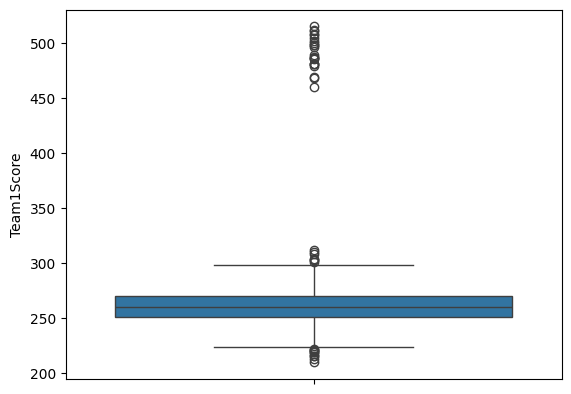

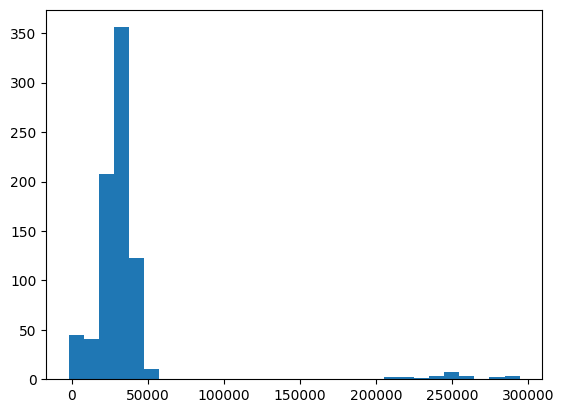

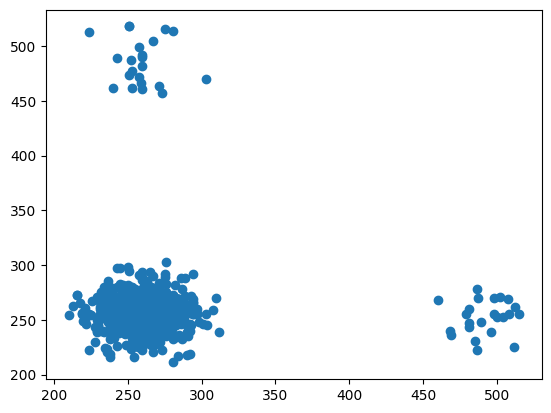

In [35]:
# e) Visualizations
sns.boxplot(df['Team1Score'])
plt.show()
plt.hist(df['Audience'], bins=30)
plt.show()
plt.scatter(df['Team1Score'], df['Team2Score'])
plt.show()

In [36]:
# b) Keep non-outliers (Z<3)
df_z = df[(df['T1_Z'].abs() < 3) & (df['T2_Z'].abs() < 3)]

In [37]:
# c) Replace outliers with median
median1 = df['Team1Score'].median()
median2 = df['Team2Score'].median()
df.loc[df['T1_Z'].abs() > 3, 'Team1Score'] = median1
df.loc[df['T2_Z'].abs() > 3, 'Team2Score'] = median2

In [38]:
# d) IQR filter
Q1 = df['Team1Score'].quantile(0.25)
Q3 = df['Team1Score'].quantile(0.75)
IQR = Q3 - Q1
df_iqr = df[(df['Team1Score'] >= Q1 - 1.5*IQR) & (df['Team1Score'] <= Q3 + 1.5*IQR)]

In [39]:
df.shape

(806, 17)

# Step 11: Encoding Categorical Variables

In [ ]:
# a) Label encode selected columns (Good for tree-based models)
le = LabelEncoder()
# We keep a copy of original for One-Hot Encoding demonstration
df_encoded = df.copy()

for col in ['Team1','Team2','Stadium','Weather','TossWinner','RainAffected']:
    df[col] = le.fit_transform(df[col].astype(str))

# b) One-Hot Encoding (Better for linear models/neural networks)
# Example: One-Hot Encode 'Weather' and 'Stadium' in a separate dataframe or the main one
# This creates binary columns like Weather_Sunny, Weather_Rainy
df_onehot = pd.get_dummies(df_encoded, columns=['Weather', 'RainAffected'], drop_first=True)

print("Label Encoded columns:")
print(df[['Team1', 'Weather']].head())
print("\nOne-Hot Encoded columns sample:")
print(df_onehot.filter(like='Weather').head())

# Step 12: Data Visualization

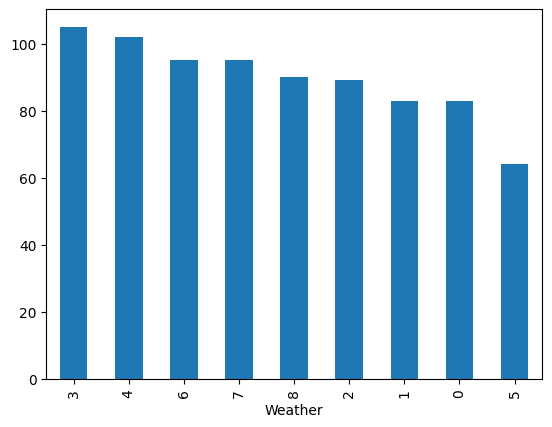

In [41]:
# a) Weather bar chart
df['Weather'].value_counts().plot(kind='bar')
plt.show()

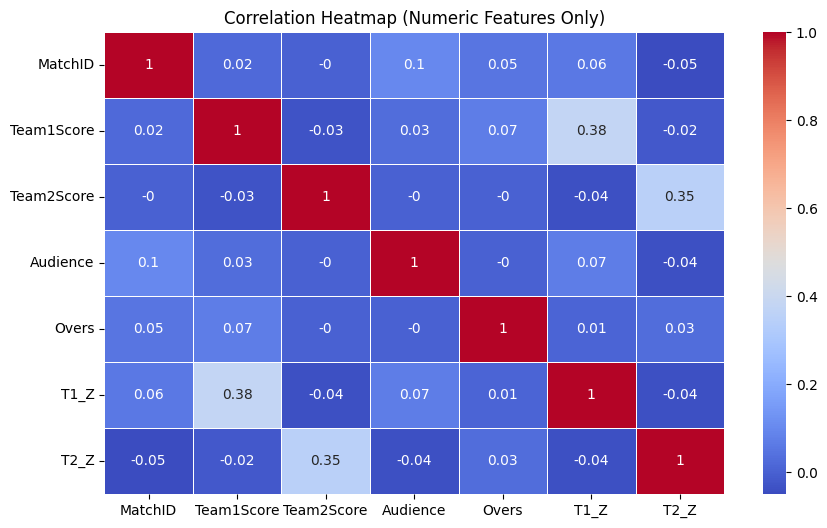

In [42]:
# d) Correlation heatmap
numeric_df = df.select_dtypes(include=['int64','float64'])
plt.show()
plt.figure(figsize=(10,6))
sns.heatmap(
    numeric_df.corr().round(2),
    annot=True,
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()



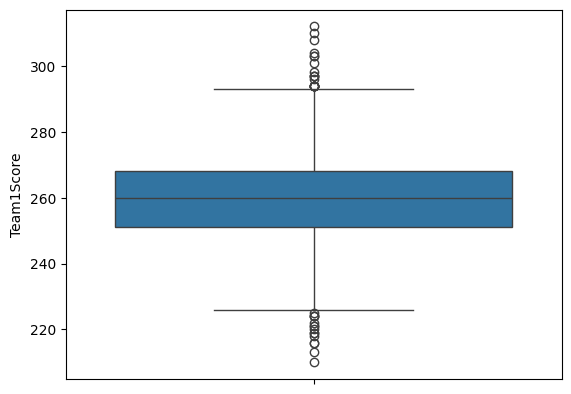

In [43]:
# c) Team1Score boxplot
sns.boxplot(df['Team1Score'])
plt.show()

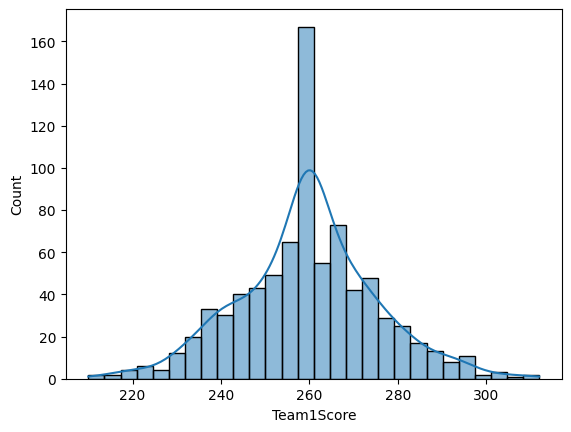

In [44]:
# b) Team1Score histogram + KDE
sns.histplot(df['Team1Score'], kde=True)
plt.show()

# Step 13: Normalization

In [45]:
# a) Min-Max normalization
mm = MinMaxScaler()
df[['T1_MM','T2_MM','Aud_MM']] = mm.fit_transform(
    df[['Team1Score','Team2Score','Audience']]
)

In [46]:
# b) Z-Score standardization
zs = StandardScaler()
df[['T1_ZN','T2_ZN','Aud_ZN']] = zs.fit_transform(
    df[['Team1Score','Team2Score','Audience']]
)